### import necessary library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### load data

In [2]:
df = pd.read_csv('spam.tsv', sep='\t')

In [3]:
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [4]:
df['message'].iloc[0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [5]:
df.tail()

,label,message,length,punct
5567,spam,This is the 2nd time we have tried 2 contact u...,160,8
5568,ham,Will ü b going to esplanade fr home?,36,1
5569,ham,"Pity, * was in mood for that. So...any other s...",57,7
5570,ham,The guy did some bitching but I acted like i'd...,125,1
5571,ham,Rofl. Its true to its name,26,1


### exploratory data analysis

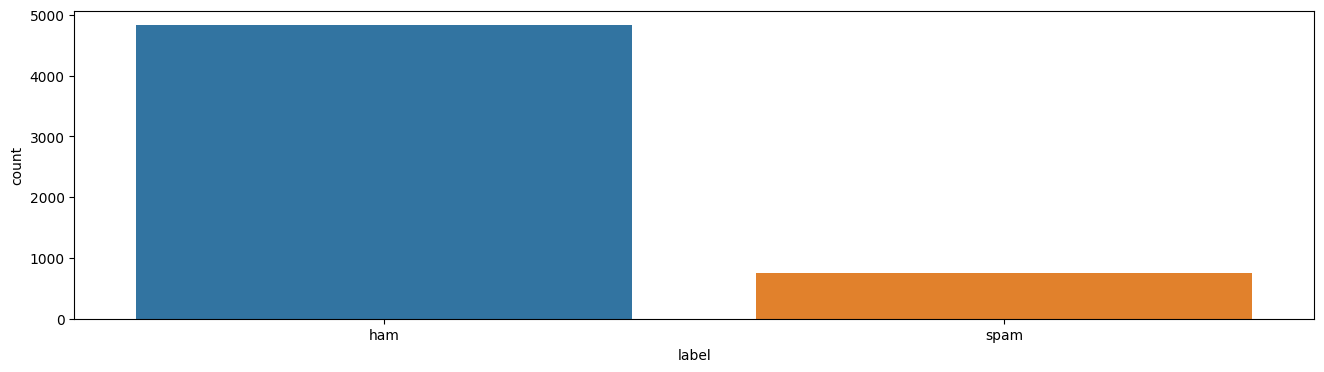

In [6]:
plt.figure(figsize=(16, 4))
sns.countplot(data=df, x='label')
plt.show()

In [7]:
print(df['label'].value_counts()/len(df))

ham     0.865937
spam    0.134063
Name: label, dtype: float64


In [8]:
df.isna().sum()

label      0
message    0
length     0
punct      0
dtype: int64

### data preprocessing

In [9]:
ham = df[df['label'] == 'ham']
spam = df[df['label'] == 'spam']

In [10]:
ham = ham.sample(len(spam))
len(ham), len(spam)

(747, 747)

In [11]:
df = ham.append(spam, ignore_index=True)

C:\Users\yandiher\AppData\Local\Temp\ipykernel_10108\2145385498.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = ham.append(spam, ignore_index=True)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    1494 non-null   object
 1   message  1494 non-null   object
 2   length   1494 non-null   int64 
 3   punct    1494 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.8+ KB


### building algorithm

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [14]:
x = df['message'].values
y = df['label'].values
xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size=0.8, random_state=42, stratify=y)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [16]:
models = [RandomForestClassifier(),
          LogisticRegression(),
          KNeighborsClassifier(),
          SVC()]

names = ['RandomForestClassifier',
         'LogisticRegression',
         'KNeighborsClassifier',
         'SVC']

In [17]:
scores = []
for model in models:
    clf = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', model)])
    clf.fit(xTrain, yTrain)
    score = clf.score(xTest, yTest)
    scores.append(score)

comparison = pd.DataFrame(data={'names': names, 'scores': scores},
                          columns=['names', 'scores']).sort_values(by=['scores'], ascending=False)

In [18]:
comparison

,names,scores
3,SVC,0.966555
0,RandomForestClassifier,0.956522
1,LogisticRegression,0.953177
2,KNeighborsClassifier,0.929766


In [19]:
clf = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', SVC())])
clf.fit(xTrain, yTrain)
prediction = clf.predict(xTest)

In [20]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [21]:
print(classification_report(yTest, prediction))

              precision    recall  f1-score   support

         ham       0.95      0.99      0.97       150
        spam       0.99      0.95      0.97       149

    accuracy                           0.97       299
   macro avg       0.97      0.97      0.97       299
weighted avg       0.97      0.97      0.97       299



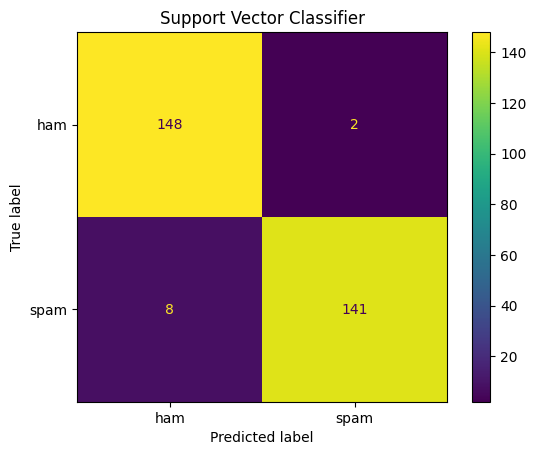

In [22]:
ConfusionMatrixDisplay.from_predictions(yTest, prediction)
plt.title(label='Support Vector Classifier')
plt.show()

### grid search

In [23]:
vectorizer = TfidfVectorizer()

In [24]:
vectorizer.fit(x)

TfidfVectorizer()

In [25]:
x = vectorizer.transform(x)
y = pd.get_dummies(data=y, drop_first=True)
y = y.values.ravel()

In [26]:
params = {'C': [0.001, 0.01, 0.1, 1],
          'kernel': ['rbf', 'poly', 'linear'],
          'gamma': [0.1, 1, 10, 100]}

In [27]:
grid = GridSearchCV(estimator=SVC(), param_grid=params, cv=5, scoring='accuracy')
grid.fit(x, y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['rbf', 'poly', 'linear']},
             scoring='accuracy')

In [28]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
0.9544903593634262


In [29]:
clf = SVC(**grid.best_params_)
clf.fit(x, y)

SVC(C=1, gamma=0.1, kernel='linear')

In [30]:
test = ['free tickets if you click this button. get your seat now!!!']
test

['free tickets if you click this button. get your seat now!!!']

In [31]:
test = vectorizer.transform(test)
if clf.predict(test) == 1:
    print('this message is spam')
else:
    print('this message is ham')

this message is spam
